
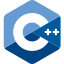
<br>

<div style="text-align:center; font-size:200%;">
  <b>GoF: Observer Pattern</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 01 GoF Observer Pattern.ipynb -->
<!-- slides/module_450_design_patterns/topic_240_observer.cpp -->


## Observer

### Intent

- One-to-many dependency between objects
- Notify all dependents automatically when state changes

### Motivation

- Maintain consistency between related objects
- While avoiding tight coupling
- Allow a *Subject* to have any number of *Observers*
- Notify *Observers* automatically about changes to the *Subject*


- Stock prices change constantly
- Many different applications want to be informed about changes
- Applications should be independent of each other
- The application should not know about concrete applications


### Class diagram

<img src="img/stock_example.svg"
     style="display:block;margin:auto;width:90%"/>

In [ ]:
#include <cmath>
#include <iostream>
#include <memory>
#include <random>
#include <string>
#include <unordered_map>
#include <vector>

In [ ]:
class Stock {
public:
    Stock(std::string name, double price) : name(name), price(price) {}

    std::string GetName() const { return name; }
    double GetPrice() const { return price; }

    void SetPrice(double new_price) { price = new_price; }

private:
    std::string name;
    double price;
};

In [ ]:
class StockObserver {
public:
    StockObserver() = default;
    StockObserver(const StockObserver&) = delete;
    StockObserver& operator=(const StockObserver&) = delete;
    StockObserver(StockObserver&&) = delete;
    StockObserver& operator=(StockObserver&&) = delete;
    virtual ~StockObserver() = default;

    virtual void NoteUpdatedPrices(const std::vector<Stock*>& stocks) = 0;
}

In [ ]:
class StockMarket {
public:
    void AddStock(std::unique_ptr<Stock> stock);
    void AttachObserver(std::shared_ptr<StockObserver> observer);
    void UpdatePrices();

private:
    std::size_t GetNumStocksToSelect() const;
    std::vector<Stock*> SelectStocksToUpdate() const;
    void UpdatePricesFor(std::vector<Stock*> stocks) const;
    void NotifyObservers(const std::vector<Stock*>& stocks);

    std::unordered_map<std::string, std::unique_ptr<Stock>> stocks;
    std::vector<std::weak_ptr<StockObserver>> observers;
    std::random_device rd;
    mutable std::mt19937 gen{rd()};
    mutable std::normal_distribution<> price_dist{1.0, 0.3};
};

In [ ]:
void StockMarket::AddStock(std::unique_ptr<Stock> stock) {
    std::string name{stock->GetName()};
    stocks[name] = std::move(stock);
}

In [ ]:
void StockMarket::AttachObserver(std::shared_ptr<StockObserver> observer) {
    observers.push_back(observer);
}

In [ ]:
void StockMarket::UpdatePrices() {
    auto stocks{SelectStocksToUpdate()};
    UpdatePricesFor(stocks);
    NotifyObservers(stocks);
}

In [ ]:
std::size_t StockMarket::GetNumStocksToSelect() const {
    auto percent_dist{std::binomial_distribution<std::size_t>(stocks.size(), 0.4)};
    return percent_dist(gen);
}

In [ ]:
std::vector<Stock*> StockMarket::SelectStocksToUpdate() const {
    std::vector<Stock*> stocksToUpdate;
    stocksToUpdate.reserve(stocks.size());
    std::transform(
        stocks.begin(), stocks.end(), std::back_inserter(stocksToUpdate),
        [](const auto& entry) { return entry.second.get(); });
    std::shuffle(stocksToUpdate.begin(), stocksToUpdate.end(), gen);
    stocksToUpdate.resize(GetNumStocksToSelect());
    return stocksToUpdate;
}

In [ ]:
void StockMarket::UpdatePricesFor(std::vector<Stock*> stocks) const {
    for (auto stock : stocks) {
        stock->SetPrice(stock->GetPrice() * price_dist(gen));
    }
}

In [ ]:
void StockMarket::NotifyObservers(const std::vector<Stock*>& stocks) {
    for (auto& observer : observers) {
        std::shared_ptr<StockObserver> observer_ptr{observer.lock()};
        if (observer_ptr)
            observer_ptr->NoteUpdatedPrices(stocks);
    }
}

In [ ]:
class PrintingStockObserver : public StockObserver {
public:
    PrintingStockObserver(std::string name) : name(name) {}

    void NoteUpdatedPrices(const std::vector<Stock*>& stocks) override {
        std::cout << "PrintingStockObserver " << name << " received update:\n";
        for (auto stock : stocks) {
            std::cout << "  " << stock->GetName() << ": " << stock->GetPrice() << "\n";
        }
    }

private:
    std::string name;
};

In [ ]:
class RisingStockObserver : public StockObserver {
public:
    RisingStockObserver(std::string name) : name(name) {}

    void NoteUpdatedPrices(const std::vector<Stock*>& stocks) override {
        std::cout << "RisingStockObserver " << name << " received update:\n";
        for (auto stock : stocks) {
            auto oldPrice{oldPrices[stock->GetName()]};
            if (stock->GetPrice() > oldPrice)
                std::cout << "  " << stock->GetName() << ": " << oldPrice << " -> "
                          << stock->GetPrice() << "\n";
            oldPrices[stock->GetName()] = stock->GetPrice();
        }
    }

private:
    std::string name;
    std::unordered_map<std::string, double> oldPrices;
};

In [ ]:
StockMarket market;

In [ ]:
auto printingObserver{std::make_shared<PrintingStockObserver>("PrintingObserver")};
auto risingObserver{std::make_shared<RisingStockObserver>("RisingObserver")};

In [ ]:
market.AttachObserver(printingObserver);
market.AttachObserver(risingObserver);

In [ ]:
market.AddStock(std::make_unique<Stock>("Banana", 100.0));
market.AddStock(std::make_unique<Stock>("Billionz", 200.0));
market.AddStock(std::make_unique<Stock>("Macrosoft", 300.0));
market.AddStock(std::make_unique<Stock>("BCD", 400.0));

In [ ]:
for (int i = 0; i < 10; ++i) {
    std::cout << "============= Update " << i + 1 << " =============\n";
    market.UpdatePrices();
}

In [ ]:
printingObserver.reset();

In [ ]:
for (int i = 0; i < 10; ++i) {
    std::cout << "============= Update " << i + 1 << " =============\n";
    market.UpdatePrices();
}


### Applicability

- An Object needs to notify other objects without making assumptions about
  them
- A change in one object causes change in several others and you don't know
  exactly how many or which ones
- An abstraction has two aspects and one of them depends on the other


### Structure: Pull Observer

<img src="img/pat_observer_pull.svg"
     style="display:block;margin:auto;width:100%"/>


## Observer (Behavioral Pattern)

### Participants

- `Subject`
  - Knows its observers. Any number of Observer objects may observe a subject
  - Provides an interface for attaching and detaching Observer objects
- `Observer`
  - Defines an updating interface for objects that should be notified of
    changes in a subject


- `ConcreteSubject`
  - Stores state of interest to `ConcreteObserver` objects
  - Sends a notification to its observers when its state changes
- `ConcreteObserver`
  - May maintain a reference to a `ConcreteSubject` object
  - Stores state that should stay consistent with the subject's
  - Implements the `Observer` updating interface to keep its state
    consistent with the subject's


### Collaborations: Pull Observer

<img src="img/pat_observer_pull_seq.svg"
     style="display:block;margin:auto;width:65%"/>


### Collaborations

- `ConcreteSubject` notifies its observers about changes in its state
- After being informed of a change in the concrete subject, a
  `ConcreteObserver` object gets the new state from the subject
- `ConcreteObserver` uses this information to reconcile its state with that
  of the subject


### Structure: Push Observer

<img src="img/pat_observer_push.svg"
     style="display:block;margin:auto;width:100%"/>


### Interaction: Push Observer

<img src="img/pat_observer_push_seq.svg"
     style="display:block;margin:auto;width:65%"/>


### Consequences

- `Subject` and `Observer` can
  - vary independently
  - be independently reused
- Abstract coupling between Subject and Observer
- Support for broadcast communication
- Unexpected updates


### Known uses

Event listeners in user interfaces (SWT)

### Related Patterns

- Mediator: By encapsulating complex update semantics, the `ChangeManager`
  acts as mediator between subjects and observers
- Singleton: ...


## Workshop: Item-Producer

In a production system you want to notify various other systems when you have
produced a workpiece. These systems should be independent of the concrete
producer and also the producer should have no (static) knowledge about the
notified systems.

Implement such a system with the Observer pattern. To do this, implement a
concrete observer `PrintingObserver` that prints the state of the observed
object.

*Hint:* You can implement the system with both pull and push observers. It is
a good exercise to implement and compare both variants.